In [2]:
#与评估1不同的是，把两部分数据合并
import struct
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import datetime
import glob
import pandas as pd
from itertools import islice  
import xgboost as xgb
from model_config import *
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from scipy import stats
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
#from treesbo.tuning import main_tuning_with_bo
%matplotlib inline
import matplotlib.pyplot as plt
import joblib

In [3]:
def func_evaluation(y_real, y_pred, verbose=True):
    """
    y_real: real values
    y_pred: prediction values
    MAKE THEM HAVE THE SHAPE OF (N,) FIRST BY USING ndarray.ravel()
    """
    if not isinstance(y_real, np.ndarray):
        y_real = np.array(y_real)
    if not isinstance(y_pred, np.ndarray):
        y_pred = np.array(y_pred)
    y_real = y_real.ravel()
    y_pred = y_pred.ravel()

    # MAPE
    def cal_mape(y_true, y_pred):
        y_true = np.where(y_true == 0, 1, y_true)  # To avoid zeros.
        mape = np.mean(abs((y_true.ravel() - y_pred.ravel()) / y_true.ravel()))
        return mape

    m0 = stats.pearsonr(y_real, y_pred)[0]
    m1 = r2_score(y_real, y_pred)
    m2 = explained_variance_score(y_real, y_pred)
    m3 = mean_squared_error(y_real, y_pred)
    m4 = mean_absolute_error(y_real, y_pred)
    m5 = cal_mape(y_real, y_pred)
    if verbose:
        print("模型的评估结果:")
        print(
            'PersonR: %f \nRMSE: %f \nR2: %f \nExplained Variance: %f \nMSE: %f \nMAE: %f \nMAPE: %f'
            % (m0, np.sqrt(m3), m1, m2, m3, m4, m5))
    return m0, np.sqrt(m3), m1, m2, m3, m4, m5



In [4]:
pre1 = np.load('./pre_99pro.npz')['sequence_array']
pre2 = np.load('./pre.npz')['sequence_array']
true1 = np.load('./tru_99pro.npz')['sequence_array']
true2 = np.load('./tru.npz')['sequence_array']

In [5]:
pre=np.hstack((pre1,pre2))
true=np.hstack((true1,true2))
print(pre.shape)

(1276502300,)


In [6]:
#共有100层，每层有23条廓线，每个文件有555001个波数。555001*23*100=1276502300
#画一张横坐标是波数，纵坐标是层数，bias的二维分布图。
bias=np.array([])
for i in range(0,pre.shape[0],23*555001):
    #print(abs(pre[i:i+23*555001]-true[i:i+23*555001]).shape)
    tmp=np.mean(abs(pre[i:i+23*555001]-true[i:i+23*555001]).reshape(23,555001),axis=0)
    bias=np.append(bias,tmp)
print(bias.shape)

(55500100,)


(100, 555001)


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


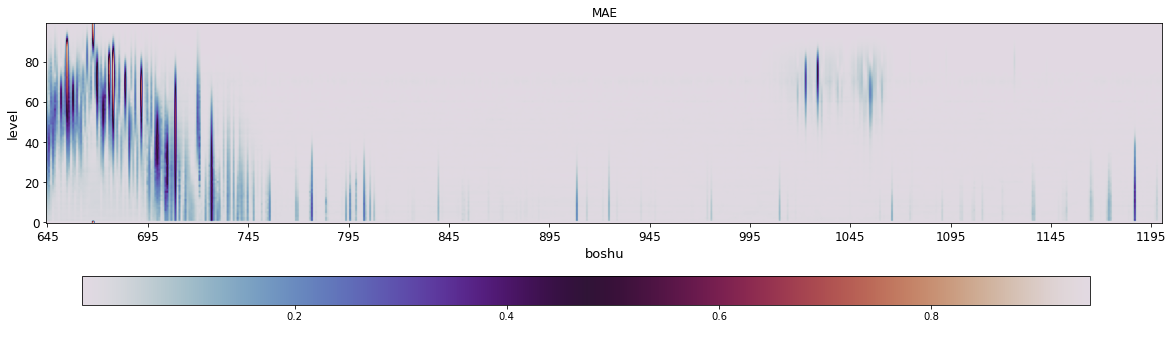

In [7]:
bias=bias.reshape(100,555001)
print(bias.shape)
%matplotlib inline
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111) 
#label=[i for i in np.arange(645.0,1200.1,0.001)] # 填写自己的标签
#ax1.set_xticklabels(label)
im=ax1.imshow(bias[:,::1000],origin='lower',cmap='twilight')
plt.xticks(np.arange(0, 555.001, 50), np.arange(645, 1200, 50))
plt.tick_params(labelsize=12)



#设置横纵坐标的名称以及对应字体格式
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 13,
}
plt.xlabel('boshu',font2)
plt.ylabel('level',font2)
plt.title('MAE')
#设置图例并且设置图例的字体及大小
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 13,
}
position=fig.add_axes([0.15, 0.25, 0.7, 0.04])#位置[右移,上移,拉宽,压缩高度]
cb=plt.colorbar(im,cax=position,orientation='horizontal')#方向
cb.set_label(' ',fontdict=font1) #设置colorbar的标签字体及其大小

plt.savefig('MAE-RF-add-charas.png',dpi=100)
plt.show()